# Rebirth the Remains
## An NLP analysis over two great brands of Brazilian Heavy Metal: Angra and Sepultura


### Motivation
In most of my time I used to experiment some NLP techniques and I noticed thjat even with the pletora of resources available, it's very hard to find some NLP Tech stuff attached with Data Analysis, _i.e._ related to generate knowledge over the data like Text Mining. 

And this is what this post what about.  

### Why Angra and Sepultura?  
Heavy Metal it's one of the most boardeless music styles in the world and I would like to show two of the most iconic bands of my country and their literary characteristics in a simple way.  

### About the Bands

#### Sepultura
According to [Wikipedia](https://en.wikipedia.org/wiki/Sepultura), Sepultura is a Brazilian heavy metal band from Belo Horizonte. Formed in 1984 by brothers Max and Igor Cavalera, the band was a major force in the groove metal, thrash metal, and death metal genres during the late 1980s and early 1990s. Sepultura has also been credited as one of the second wave of thrash metal acts from the late 1980s and early-to-mid 1990s.  

[Sepultura Oficial Website](https://www.sepultura.com.br/) - [Sepultura in Spotify](https://open.spotify.com/artist/6JW8wliOEwaDZ231ZY7cf4)

#### Angra
According to [Wikipedia](https://en.wikipedia.org/wiki/Angra_(band)), Angra is a Brazilian heavy metal band formed in 1991 that has gone through some line-up changes since its foundation. Led by Rafael Bittencourt, the band has gained a degree of popularity in Japan and Europe.   

[Angra Oficial Website](http://www.angra.net/) - [Angra in Spotify](https://open.spotify.com/artist/7IAXZaLTb6nkJr8RmVPn5y)



### Questions
Some personal questions that I always had about these bands and I'll try to answer with this notebook is: 
- 1) What's the literary characteristics for Angra and Sepultura?
- 2) Which type of thematics they talk about?
- 3) Who has more diversity in their topics?

### Some limitations 

- NLP it's still an unsolved problem even with all [over promissing](https://openai.com/blog/better-language-models/) about it. This two anthologic pieces by [Yoav Goldberg](https://medium.com/@yoav.goldberg/an-adversarial-review-of-adversarial-generation-of-natural-language-409ac3378bd7) and [The Gradient](https://thegradient.pub/frontiers-of-generalization-in-natural-language-processing/) put that in perspective;
- The creative process even with some patterns it's a very complex that can envolves a lot of poetic license. [In this video](https://www.youtube.com/watch?v=G8eqnWVY_rU) Rafael Bittencourt explains the whole process to compose a single lyric for the new album, and in [this video](https://www.youtube.com/watch?v=kYf6GgkGfzA) Max Cavalera speaks about the creative process behind the classic album ["Roots"](https://www.youtube.com/watch?v=KuMlv7hmrFg&list=PLfUV806q_Ri4WN5omBcgzDxHcWMaHL_i1) from 1996.

### Applied techniques

#### Natual Language Processing
[Natural language processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) is a subfield of computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

#### Topic Modeling
In machine learning and natural language processing, a [Topic Model](https://en.wikipedia.org/wiki/Topic_model) is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Topic models are also referred to as probabilistic topic models, which refers to statistical algorithms for discovering the latent semantic structures of an extensive text body. 

#### Latent Dirichlet Allocation
In natural language processing, [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.  










### Data extraction and load
To extract the lyrics I used [`PyLyrics`](https://github.com/geekpradd/PyLyrics) library using [this script](https://github.com/fclesio/metalbr/blob/master/data-extraction.py). Important: This library doesn't have any update/bug fix since last year. 







In [1]:
import os 
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import string
import nltk
import random
from collections import Counter
from spacy.lang.en import English


random.seed(42)
np.random.seed(42)

# Define function to cleanup text by removing 
# personal pronouns, stopwords, and puncuation
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

# Datasets
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, 'data/rebirth-remains.csv')

# Load file
df_raw_lyrics = pd.read_csv(filename, index_col=False)
df_raw_lyrics.columns = ['index','artist','album','lyric']

# Backup to not use the Google API to get the language again
df = df_raw_lyrics

# One limitation of the wrapper that I used to get the data
# it's that contains a lot of bad records
df_raw_lyrics = df_raw_lyrics[pd.notnull(df_raw_lyrics['lyric'])]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<span style=")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("padding")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<img")]

# Basic counters
print(f'Qty rows: {df_raw_lyrics.shape[0]}, Qty columns: {df_raw_lyrics.shape[1]}')

# First look in the data
df_raw_lyrics.head(5)

Qty rows: 325, Qty columns: 4


,index,artist,album,lyric
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea..."
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...


The wrapper fetched 325 songs bringing the artist , lyric, and album.  

One of the main challenges it's that these band susually write songs in multi-language (EN and PT-BR). For a matter of simplicity we'll concentrate only in the EN language.  

To filter the PT-BR songs I'll use `textblob` library that uses the Google API to check the language. The main caveat it's if you re-run a lot of times maybe you receive the code `HTTP Error 429: Too Many Requests`. 

In [2]:
def get_language(text):
    from textblob import TextBlob
    text = str(text)
    b = TextBlob(text)
    return b.detect_language()

# Include language in the DF
df_raw_lyrics['lang'] = df_raw_lyrics['lyric'].apply(get_language)

# Show stats about the language per artist
df_raw_lyrics.groupby(['artist', 'lang']).size().reset_index()

,artist,lang,0
0,angra,en,119
1,angra,pt,4
2,sepultura,en,194
3,sepultura,ja,1
4,sepultura,pt,7


Here we can see that from 325 lyrics 38% is from Angra and 62% is from Sepultura. Angra have 96% (119) of all dataframe lyrics in EN and Sepultura have 96% (194) of all lyrics in EN. 

The most remarkble song in PT-BR from Angra (IMHO) it's [Caça e Caçador](http://www.darklyrics.com/lyrics/angra/huntersandprey.html#8) what was a song from the album Hunters and Pray. In the Temple of Shadows album the song [Late Redemption](http://www.darklyrics.com/lyrics/angra/templeofshadows.html#12) it's a good piece in EN/PT-BR. 

Sepultura has some songs in PT-BR like [Filhos do Mundo](http://www.darklyrics.com/lyrics/sepultura/bestialdevastationsculoxx.html#7) from Bestial Devastation, [Prenuncio](http://www.darklyrics.com/lyrics/sepultura/against.html#17) from Against and [A Hora E A Vez Do Cabelo Nascer](https://www.letras.mus.br/sepultura/844256/) from the Beneath the Remains album that is a [cover song from Mutantes](https://www.youtube.com/watch?v=87vwhDPA8Z4). [The most remarkble](https://www.youtube.com/watch?v=4CWrVCAgcjg) one in PT-BR it's the [Policia](http://www.darklyrics.com/lyrics/sepultura/bloodrooted.html#3) song. 



In [3]:
# Filtering out non-EN songs
df_raw_lyrics = df_raw_lyrics[df_raw_lyrics['lang'] == 'en']

With all PT-BR lyrics removed let's perform a quick check in all albuns of these bands.

In [4]:
# Lyrics per album
df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()

,artist,album,0
0,angra,Angels Cry,9
1,angra,Aqua,10
2,angra,Aurora Consurgens,11
3,angra,Fireworks,11
4,angra,Freedom Call,8
5,angra,Holy Land,10
6,angra,Holy Live,4
7,angra,Hunters and Prey,7
8,angra,Omni,10
9,angra,Reaching Horizons,9


In a first look, considering our dataframe, we can see a first difference between these two bands that Sepultura has a larger discography and more songs per album.  

This can be explained with the fact that even both bands faced an hiatus in the time of that they changed their main singers ([Andre Matos](https://pt-br.facebook.com/AndreMatosOfficial/) and [Edu Falaschi](https://en.wikipedia.org/wiki/Eduardo_Falaschi) in Angra and [Max Cavalera](https://en.wikipedia.org/wiki/Max_Cavalera) by Sepultura) Sepultura released 8 albuns after their break (all of them with [Derrick Green](https://en.wikipedia.org/wiki/Derrick_Green)) and in meanwhile Angra released 6; and Sepultura it's a more profilic band.  

Let's keep that information in mind because maybe it can be explained in a second moment in this analysis. 

Let's check the average songs per album.

In [5]:
# Average songs per album
df_albuns = df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()
df_albuns.columns = ['artist', 'album', 'qty_tracks']
df_albuns.groupby(['artist']).agg({'qty_tracks': [np.size, np.mean]}).reset_index()

artist qty_tracks           
                   size       mean
0      angra         13   9.153846
1  sepultura         18  10.777778

As we visually inspected Sepultura not even have more albuns, but have more songs per album. 

To start our analysis one important aspect of Text analysis it's the Pre-Processing. Here we're literally can screw all analysis because the Pre-Processing it's responsible to remove all noise of the data and normalize all data to get meaningful results. [Kavita Ganesan](http://kavita-ganesan.com/text-preprocessing-tutorial/) made a great analysis over this topic.  


The first step will be to remove all english [stopwords](https://en.wikipedia.org/wiki/Stop_words) of all lyrics.  

PS: Personally I don't like to use of-the-shelf stopwords list because every domain demands specific words subsets to define if some word it's important or not. But let's keep that way for a matter of simplicity. This nice text of [Martina Pugliese](https://martinapugliese.github.io/english-stopwords/) explains it in detail. In terms of implementation [this article of ML Whiz](https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/) probably its the best resource available in internet. 




In [6]:
# Convert the lyrics to String to not break the posterior convertions
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].astype(str)

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
stop = ENGLISH_STOP_WORDS

# Remove all stopwords
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].apply(lambda x: ' '.join([item for item in x.lower().split() if item not in stop]))

# Quick check
df_raw_lyrics.head(5)

,index,artist,album,lyric,lang
0,0,sepultura,Bestial Devastation,"curse launched, beware lord death declared war...",en
1,1,sepultura,Bestial Devastation,legion demons born boundaries death like onsla...,en
2,2,sepultura,Bestial Devastation,born hell supreme force evil destroy altar sla...,en
3,3,sepultura,Bestial Devastation,misfits high night feel presence death way mor...,en
4,4,sepultura,Bestial Devastation,marching mist leaving weakest going endless wa...,en


After the stopwords removal, let's perform a quick visual check on the most frequent words used by these two bands. In other words: What's most used words in their composition. 

In [7]:
# Data exploration in some specific class to see the most frequent words
def get_word_frequency(artist):
    #from nltk.corpus import stopwords
    #stoplist = set(stopwords.words("english"))
    
    from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    stoplist = ENGLISH_STOP_WORDS

    # Word Frequency per Category
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=['parser', 'ner'])
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
            tokens = [tok for tok in tokens if tok not in stoplist and tok not in punctuations]
            tokens = ' '.join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [text for text in df_raw_lyrics[df_raw_lyrics['artist'] == artist]['lyric']]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = ' '.join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(31)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(31)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f'Most Common Words used by {artist}')
    plt.xticks(rotation=45)
    plt.show()

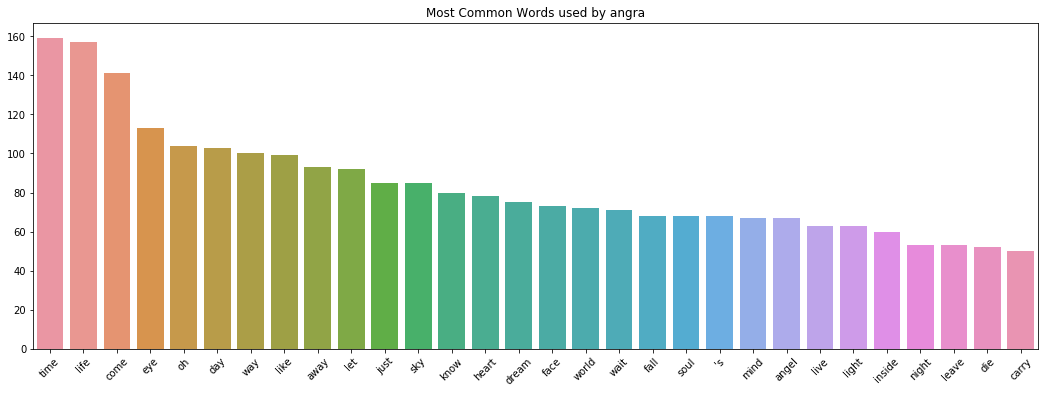

In [8]:
# Most Common words: Angra
get_word_frequency('angra')

If I could to perform some classification here to define Angra Lyrics based in their most common expressions would be like that: 

- Relation with time: `Time`, `Day`, `Wait`, `Night`  


- Feelings: `Like`, `Heart`, `Soul`, `Lie`  

    
- Moviment and distance: `Come`, `Way`, `Away`, `Carry`  


- Human issues: `Life`, `Let`, `Know`, `Dream`, `Mind`, `Live`, `inside`, `Leave`  

    
- Absolute state of the world: `Die`  

    
- Typical Heavy Metal cliche expression: `Oh`


Now, quick verification in Sepultura lyrics:

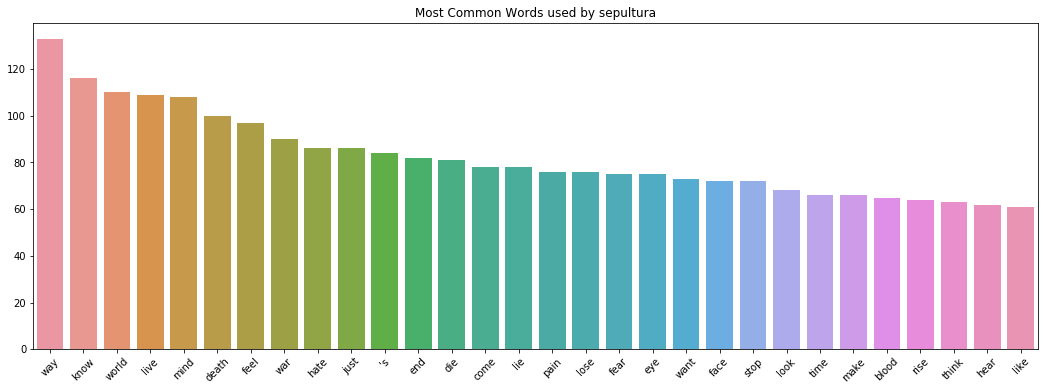

In [9]:
# Most Common words: Sepultura
get_word_frequency('sepultura')

State of the modern world: `Death`, `War`, `Hate`, `Die`, `Lie`, `Pain`, `Lose`, `Fear`, `Blood`, `World`

Action, distance and time: `Way`, `Come`, `Stop`, `Make`, `Rise`, `Time`, `Think`, `Hear`, `Know`

Mind issues: `Live`, `Mind`, `Feel`, `Want`, `Look`, `Inside`


Some latent differences about the themas discussed between Sepultura and Angra arises like:  

- The axis of compositional literature of Sepultura converges on subjects related to the theme of things/feelings linked to death, pain, war, hatred (if you already don't know, Sepultura means "serious" in PT-BR) which are considered the most aggressive/heavy themes;  

- And Angra in turn has a lighter theme talking more about existential issues that involves the passage of time, as well as some songs that have feelings linked to dreams and feelings linked to internal conflicts.  



Let's see the word cloud (Word Cloud) relative to the most frequent words of the two bands, only for the title of absolute comparison according to all the vocabulary used by the bands.

In [10]:
# Word cloud with most common words
def show_wordcloud(text, artist):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    
    from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    STOPLIST = ENGLISH_STOP_WORDS
    

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=STOPLIST, background_color="white").generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(25,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for the {artist} category', fontsize=20)
    plt.axis("off")
    plt.show()
    
def get_wordcloud(df, artist):
    dataframe = df[df['artist'] == artist]
    # Get all texts and generate a cloud
    text = " ".join(review for review in dataframe.lyric)
    show_wordcloud(text, artist) 

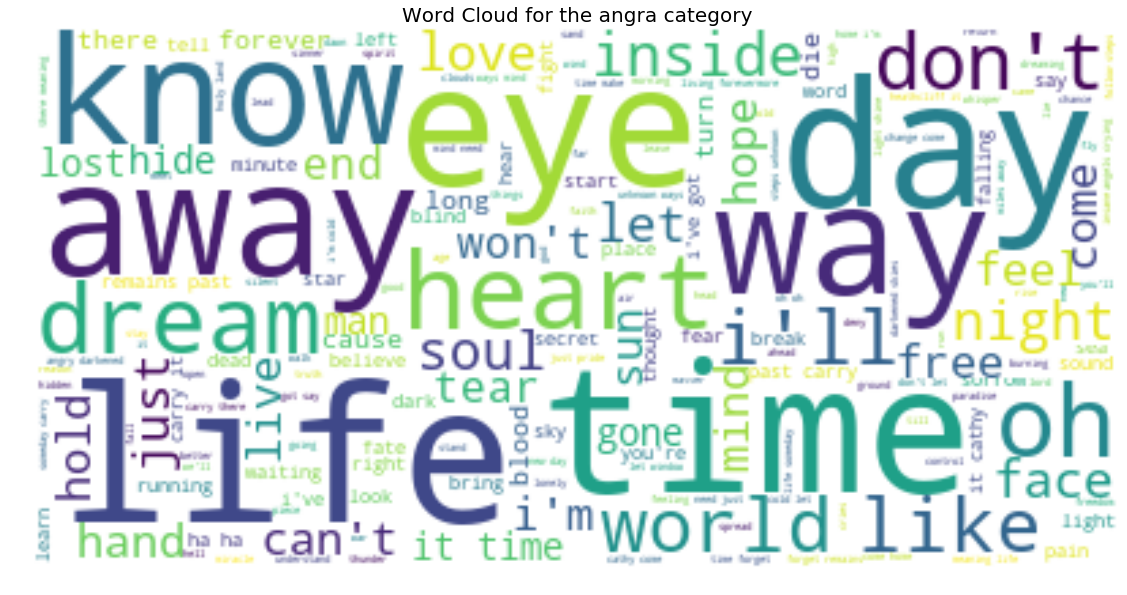

In [11]:
get_wordcloud(df_raw_lyrics, 'angra')

Main words:
 - `life`, `time`, `know`, `heart`, `day`, `away`, `know`, `dream`

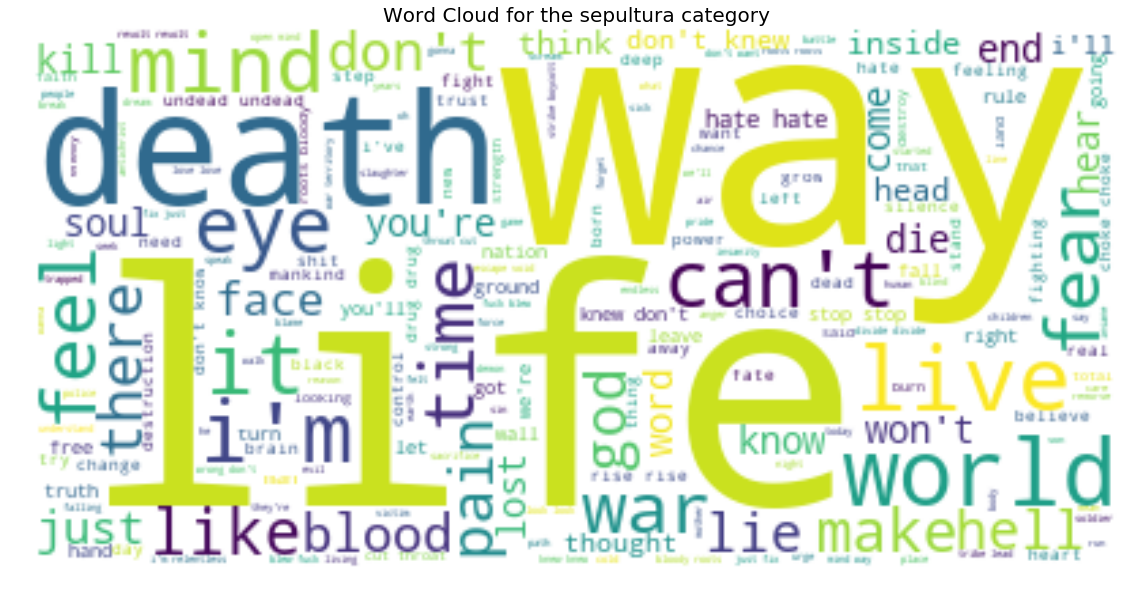

In [12]:
get_wordcloud(df_raw_lyrics, 'sepultura')

Main words:
 - `way`, `life`, `death`, `world`, `mind`
 


### Lexical Diversity

According to [Johansson](https://journals.lub.lu.se/LWPL/article/view/2273) (2009) Lexical diversity is a measure of how many different words that are used in a
text. The practical use of the Lexical Diversity it's given by [McCarthy and Jarvis](https://link.springer.com/article/10.3758%2FBRM.42.2.381) (2010) the they said that LD is the range of different words used in a text, with a greater range indicating a higher diversity.


A special consideration here it's that Heavy Metal songs (and removing Rap music that contain lots os words) doesn't contain a lot of different words or richness. It's because each band can follow a single artistic concept and _shape their creative efforts_ to some themes. 

For example [Avatasia](https://en.wikipedia.org/wiki/Avantasia) it's a supergroup of Heavy Metal that talks about fiction, fantasy and religion; and in the other side [Dream Theater](https://en.wikipedia.org/wiki/Dream_Theater) talks about almost everything since [religion](https://genius.com/Dream-theater-in-the-name-of-god-lyrics) until [modern politics](https://www.azlyrics.com/lyrics/dreamtheater/thegreatdebate.html).


With this disclaimer let's check the Lexical Diversity of this bands.

In [13]:
def get_lexical_diversity(df, artist):
    dataframe = df[df['artist'] == artist]

    full_text_count = pd.DataFrame(Counter(" ".join(dataframe["lyric"]).split()), index=[0])
    full_text_count = full_text_count.T
    full_text_count = full_text_count.reset_index()
    full_text_count.columns = ['word', 'qty']

    distinct_words = set()
    dataframe['lyric'].str.lower().str.split().apply(distinct_words.update)
    total_distinct_words = len(distinct_words)

    total_words = full_text_count['qty'].sum()

    lexical_diversity = round((total_distinct_words / total_words),2)

    print(artist, lexical_diversity)
    
    return artist, lexical_diversity

In [14]:
get_lexical_diversity(df_raw_lyrics, 'angra')

angra 0.23


('angra', 0.23)

In [15]:
get_lexical_diversity(df_raw_lyrics, 'sepultura')

sepultura 0.24


('sepultura', 0.24)

There's no lexical diversity differences between them, _i.e._ even using different words to shape their themas, there's no substantial lexical differences between them in terms of frequency in their themes.


### Word NGrams

According to Wikipedia [n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application](https://en.wikipedia.org/wiki/N-gram). 

In other others, n-grams it's sequences that contains _n_ words that can be used to model the probability of some sequence appears in a corpus, in our case, the n-gram(s) we can examine the most frequent combination of _n_ words in their literary dictionary.

For a matter of simplicity will focus in combinations of Bigrams `n=2` e Trigrams `n=3`.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def get_word_ngrams_list(df, artist, word_ngram):

    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


    common_words = get_top_word_n_bigram(df[df['artist'] == artist]['lyric'], 20)
    df3 = pd.DataFrame(common_words, columns = ['desc' , 'count'])

    return df3

In [17]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 2)

,desc,count
0,you re,53
1,carry on,29
2,it time,27
3,ve got,25
4,remains past,24
5,we re,24
6,you ve,24
7,ha ha,19
8,it me,18
9,me cathy,18


Here we can see some things:

- The most frequent bigrama is `carry on` but this has a reason for the data: In this data set we have the `Angels Cry` and `Holy Live` disks that contain the song [Carry On](https://www.azlyrics.com/lyrics/angra/carryon.html) and this causes a _double counting_;  

- The reason behind of the `me cathy` and `cathy come` bigrams appears it's because of a cover song called [_Wuthering Heights_](https://www.azlyrics.com/lyrics/angra/wutheringheights.html) from [Kate Bush](https://en.wikipedia.org/wiki/Kate_Bush) that repeats this chorus a lot;  

- We have the tradicional heavy metal song chorus filler cliche `oh oh` appearing
    


In [18]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 3)

,desc,count
0,it me cathy,18
1,carry on it,16
2,on it time,16
3,it time forget,16
4,time forget remains,16
5,forget remains past,16
6,remains past carry,16
7,angry darkened skies,16
8,heathcliff it me,16
9,me cathy come,16


- Again appears carry on in `carry on time`, `on time forget`, `remains past carry`, 
- `Cathy` Trigrams appears in: `heathcliff me cathy`, `me cathy come`,  `cathy come home`
- Some bizzare pattern like `ha ha ha`, probably because the data cleasing


### Sepultura

In [19]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 2)

,desc,count
0,we re,48
1,you re,41
2,no no,39
3,knew don,30
4,you ll,29
5,stop me,27
6,undead undead,24
7,me stop,21
8,choke choke,21
9,hate you,20


In these bi-grams we can already see a little more of Sepultura's theme linked to themes related to brutality as I had put it before. Some mentions:
- The song "Choke" has a very repetitive chorus, and that contributes to this composition of bi-grams.
- The same thing with the classic "Roots" that has a very striking chorus

Let's go to the tri-grams

In [20]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 3)

,desc,count
0,no no no,26
1,undead undead undead,22
2,stop me stop,21
3,hate you hate,20
4,roots bloody roots,16
5,knew it knew,16
6,don that knew,16
7,cut throat cut,15
8,throat cut throat,15
9,me stop me,14


Here we see basically the same pattern with part of the tri-grams facing some very striking choruses.

Now we know a little about the theme of the two bands, however a question that follows is: Within this theme what are the latent topics behind each composition, i.e., given that there is a diversity within the themes if we could group these songs according to their literary composition as it would be?

And here's where we're going to use LDA. 


### LDA

First we will filter each of the artists within their respective dataframes:

In [21]:
# LDA Analysis
df_raw_lyrics_angra = df_raw_lyrics[df_raw_lyrics['artist'] == 'angra']
df_raw_lyrics_sepultura = df_raw_lyrics[df_raw_lyrics['artist'] == 'sepultura']

To make the distinction of the topics I arbitrarily chose 10 topics for each artist (it can be more or less) only for didactic purposes and maintenance of simplicity. 

In other words: Given all the letters of Angra and Sepultura, what are the top 10 topics that they usually make up?

In [22]:
def get_topics(df, n_components, number_words):
    # Convert to list
    data = df.lyric.values.tolist()

    # Remove special characters
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    vectorizer = CountVectorizer(analyzer='word',       
                                 min_df=10,                        # minimum reqd occurences of a word 
                                 stop_words='english',             # remove stop words
                                 lowercase=True,                   # convert all words to lowercase
                                 token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                 # max_features=50000,             # max number of uniq words
                                )

    data_vectorized = vectorizer.fit_transform(data)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

    # Build LDA Model
    from sklearn.decomposition import LatentDirichletAllocation

    lda_model = LatentDirichletAllocation(n_components=n_components,               # Number of topics
                                          max_iter=10,               # Max learning iterations
                                          learning_method='online',   
                                          random_state=100,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1, # compute perplexity every n iters, default: Don't
                                          n_jobs = -1,               # Use all available CPUs
                                         )
    lda_output = lda_model.fit_transform(data_vectorized)

    # Helper function
    def print_topics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(" ".join([words[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    lda_model.fit(data_vectorized)

    print_topics(lda_model, vectorizer, number_words)
    
    return lda_model, data_vectorized, data, lda_output, vectorizer

In [23]:
lda_model_angra, data_vectorized_angra, data_angra, lda_output_angra, vectorizer_angra = get_topics(df_raw_lyrics_angra,
                                                                                  n_components=10,
                                                                                  number_words=10)

Sparsicity:  15.461086395342448 %
Topics found via LDA:

Topic #0:
theres time dont sun cause away feel youre end way

Topic #1:
come let cold soul coming dont like away life dreams

Topic #2:
day eyes life dont just fate afraid insane wont soul

Topic #3:
away heart day know night soul hear hope eyes lives

Topic #4:
time life eyes past mind remains just forget way world

Topic #5:
angels just skies life ive try come like living fly

Topic #6:
let way ill away soul wont free know world fly

Topic #7:
like understand life steps wonder mind standing place going little

Topic #8:
life angels new dreams forever day thunder past freedom inside

Topic #9:
ill time land sun light way life end love like


In [24]:
lda_model_sepultura, data_vectorized_sepultura, data_sepultura, lda_output_sepultura, vectorizer_sepultura = get_topics(df_raw_lyrics_sepultura,
                                                                                                  n_components=10,
                                                                                                  number_words=10)

Sparsicity:  9.963501312672088 %
Topics found via LDA:

Topic #0:
just lost fear blood ive thought world inside truth mind

Topic #1:
dead born end bloody come alive dont ill walls land

Topic #2:
hell death die lost started way living life born war

Topic #3:
nation want greed change know got brain make time power

Topic #4:
false mind life like sight trust pain going fear face

Topic #5:
live wont time eyes fight god force like leave day

Topic #6:
stop want cause dont soul theres lost need wall coming

Topic #7:
hate war love life death insane world hear urge silence

Topic #8:
way walk mind wont live think choice lost open turn

Topic #9:
dont world know life away look eyes wrong end fuck


# Topic Per Document  

One important thing that we can do it's to generate a topic score for each document and based on that see which topic it's more dominant in certain document. This is important because language can have several overlaps and combinations in words and ambiguity.  

One thing that can be made it's to define some score to assess the "purity" of some document inside a particular topic.  

Anyways this is a list of the 15 first tracks and their topics. 

In [25]:
def get_topic_per_document(lda_model, data_vectorized, data, lda_output):
    # Create Document - Topic Matrix
    lda_output = lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(len(data))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    # Styling
    def color_green(val):
        color = 'green' if val > .1 else 'black'
        return 'color: {col}'.format(col=color)

    def make_bold(val):
        weight = 700 if val > .1 else 400
        return 'font-weight: {weight}'.format(weight=weight)

    # Apply Style
    df_document_topics_styled = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    
    return df_document_topics_styled, df_document_topic

In [26]:
df_topic_per_document_angra_styled, df_topic_per_document_angra = get_topic_per_document(lda_model_angra,
                                                                                         data_vectorized_angra,
                                                                                         data_angra,
                                                                                         lda_output_angra)
df_topic_per_document_angra_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0.99,0,0,0,0,0,4
Doc1,0,0.16,0,0,0.56,0,0,0,0,0.27,4
Doc2,0,0,0,0,0,0.99,0,0,0,0,5
Doc3,0,0.98,0,0,0,0,0,0,0,0,1
Doc4,0,0,0,0,0,0,0,0.98,0,0,7
Doc5,0,0.98,0,0,0,0,0,0,0,0,1
Doc6,0,0,0,0,0,0,0.99,0,0,0,6
Doc7,0.99,0,0,0,0,0,0,0,0,0,0
Doc8,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,8
Doc9,0,0,0,0,0,0.98,0,0,0,0,5


In [27]:
df_topic_per_document_sepultura_styled, df_topic_per_document_sepultura = get_topic_per_document(lda_model_sepultura,
                                                                                                 data_vectorized_sepultura,
                                                                                                 data_sepultura,
                                                                                                 lda_output_sepultura)
df_topic_per_document_sepultura_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.03,0.03,0.77,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
Doc1,0.01,0.01,0.47,0.01,0.48,0.01,0.01,0.01,0.01,0.01,4
Doc2,0,0,0.96,0,0,0,0,0,0,0,2
Doc3,0,0,0.96,0,0,0,0,0,0,0,2
Doc4,0.01,0.01,0.01,0.01,0.33,0.01,0.01,0.58,0.01,0.01,7
Doc5,0.09,0.01,0.86,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2
Doc6,0,0,0.56,0,0,0.11,0,0.31,0,0,2
Doc7,0,0.19,0.58,0,0,0,0,0,0,0.2,2
Doc8,0,0,0.74,0,0,0,0,0.25,0,0,2
Doc9,0,0,0.74,0,0.23,0,0,0,0,0,2


## Topic Distribution

In [28]:
def get_topic_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    total_docs = df_topic_distribution['Num Documents'].sum()
    df_topic_distribution['perc_per_topic'] = np.round(((df_topic_distribution['Num Documents'] /total_docs) * 100), 2)

    return df_topic_distribution

In [29]:
get_topic_distribution(df_topic_per_document_angra)

,Topic Num,Num Documents,perc_per_topic
0,4,25,21.01
1,9,21,17.65
2,1,15,12.61
3,6,14,11.76
4,5,13,10.92
5,3,13,10.92
6,8,7,5.88
7,0,5,4.20
8,7,3,2.52
9,2,3,2.52


We can see here that much of Angra's theme is focused on topics 3, 4, 5 and 6 which I call the topics of life and the look inside the heart (#3), the topic of the soul that expects to live something connected to some destiny (#4), the topic of the angels of life that remain in heaven (#5) and the topic of the promised land that comes and goes (#6).
4916 - 9028

- `Topic #3: time life eyes day ill way inside away know heart`

- `Topic #4: soul ive heart eyes waiting like lives ill words fate`

- `Topic #5: life angels time theres past remains skies try lies mind`

- `Topic #6: let come away cold say land long ive face got`

In [30]:
get_topic_distribution(df_topic_per_document_sepultura)

,Topic Num,Num Documents,perc_per_topic
0,9,36,18.56
1,0,33,17.01
2,2,28,14.43
3,8,21,10.82
4,5,19,9.79
5,7,17,8.76
6,1,16,8.25
7,6,13,6.70
8,4,7,3.61
9,3,4,2.06


Sepultura concentrates on some topics such as the world's way of walking lost with the face of death (#8), the world of a hellish war with bloody death (#3), along with the topic in which we were born to believe lies in a bloody life surrounded by lies (#0) and finally the topic of the sick world in which we were born in a bloody and sick world straight to the path of death (#5).

- `Topic #8: way look away world just lost walk die theres face`

- `Topic #3: death blood hell pain inside ive feel living war world`

- `Topic #0: life live way believe mind born fear bloody lies day`

- `Topic #5: stop like dead world ill mind cause way death open`

## Word Topics
Here is only a table for us to check the order of the words in the topics that permeate the literary part of these two bands.

A special highlight here is that in this dataframe is also considered the frequency and ordinality of the word within the topic. 

In [31]:
def get_word_topics(vectorizer, lda_model):

    # Show top n keywords for each topic
    def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
        keywords = np.array(vectorizer.get_feature_names())
        topic_keywords = []
        for topic_weights in lda_model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:n_words]
            topic_keywords.append(keywords.take(top_keyword_locs))
        return topic_keywords

    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+ str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+ str(i) for i in range(df_topic_keywords.shape[0])]

    return df_topic_keywords

In [32]:
get_word_topics(vectorizer_angra, lda_model_angra)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,theres,time,dont,sun,cause,away,feel,youre,end,way
Topic 1,come,let,cold,soul,coming,dont,like,away,life,dreams
Topic 2,day,eyes,life,dont,just,fate,afraid,insane,wont,soul
Topic 3,away,heart,day,know,night,soul,hear,hope,eyes,lives
Topic 4,time,life,eyes,past,mind,remains,just,forget,way,world
Topic 5,angels,just,skies,life,ive,try,come,like,living,fly
Topic 6,let,way,ill,away,soul,wont,free,know,world,fly
Topic 7,like,understand,life,steps,wonder,mind,standing,place,going,little
Topic 8,life,angels,new,dreams,forever,day,thunder,past,freedom,inside
Topic 9,ill,time,land,sun,light,way,life,end,love,like


In [33]:
get_word_topics(vectorizer_sepultura, lda_model_sepultura)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,just,lost,fear,blood,ive,thought,world,inside,truth,mind
Topic 1,dead,born,end,bloody,come,alive,dont,ill,walls,land
Topic 2,hell,death,die,lost,started,way,living,life,born,war
Topic 3,nation,want,greed,change,know,got,brain,make,time,power
Topic 4,false,mind,life,like,sight,trust,pain,going,fear,face
Topic 5,live,wont,time,eyes,fight,god,force,like,leave,day
Topic 6,stop,want,cause,dont,soul,theres,lost,need,wall,coming
Topic 7,hate,war,love,life,death,insane,world,hear,urge,silence
Topic 8,way,walk,mind,wont,live,think,choice,lost,open,turn
Topic 9,dont,world,know,life,away,look,eyes,wrong,end,fuck


## Topic Plotting with word distribution

Here with the `pyLDAvis` library we can take a look in how the topics are distributed via visual inspection. The graph presented by `pyLDAvis` it's called Intertopic Distance Map that consists in a [two-dimensional plane whose centers are determined by computing the distance between topics, and then by using multidimensional scaling to project the intertopic distances onto two dimensions](http://www.kennyshirley.com/LDAvis/#topic=1&lambda=1&term=).

With that we're able to interpret the composition of each topic and which individual terms are most useful inside of some topic. 

A most comprehensive introduction about the LDAVis can be found in [Sievert, C., & Shirley, K. (2014). LDAvis: A method for visualizing and interpreting topics. In Proceedings of the workshop on interactive language learning, visualization, and interfaces (pp. 63-70)](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

In [34]:
def get_LDA_plot(lda_model, data_vectorized, vectorizer):
    import pyLDAvis
    import pyLDAvis.sklearn
    %matplotlib inline

    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

### LDA Plot for all Angra's Lyrics

In [35]:
get_LDA_plot(lda_model_angra, data_vectorized_angra, vectorizer_angra)

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      -57.987305   16.608030       1        1  20.941608
9      -70.784470  -89.077461       2        1  14.721808
1      113.722809   66.760521       3        1  13.273922
5        4.990411  -53.453186       4        1  12.870537
6      127.116226 -120.498581       5        1  12.498244
3      167.255447  -15.306156       6        1   9.239678
0       39.152767   21.670059       7        1   6.604470
8       29.621700 -138.254791       8        1   4.047347
7        6.017111   98.773659       9        1   3.494270
2       87.203201  -45.346657      10        1   2.308115, topic_info=    Category        Freq        Term       Total  loglift  logprob
74   Default  131.000000        life  131.000000  30.0000  30.0000
72   Default   82.000000         let   82.000000  29.0000  29.0000
2    Default   56.000000      angels   56.000000  28.0000  28.0000
76   Default   91.000000        like   91.000000  27.0000  27.0000
21   Default   78.000000         day   78.000000  26.0000  26.0000
32   Default  103.000000        eyes  103.000000  25.0000  25.0000
128  Default   48.000000      theres   48.000000  24.0000  24.0000
63   Default   56.000000         ill   56.000000  23.0000  23.0000
16   Default   74.000000        come   74.000000  22.0000  22.0000
26   Default   84.000000        dont   84.000000  21.0000  21.0000
137  Default   20.000000  understand   20.000000  20.0000  20.0000
133  Default  141.000000        time  141.000000  19.0000  19.0000
125  Default   44.000000         sun   44.000000  18.0000  18.0000
97   Default   45.000000        past   45.000000  17.0000  17.0000
4    Default   87.000000        away   87.000000  16.0000  16.0000
89   Default   54.000000        mind   54.000000  15.0000  15.0000
118  Default   55.000000        soul   55.000000  14.0000  14.0000
73   Default   37.000000        lies   37.000000  13.0000  13.0000
93   Default   36.000000         new   36.000000  12.0000  12.0000
147  Default   39.000000        wont   39.000000  11.0000  11.0000
42   Default   30.000000     forever   30.000000  10.0000  10.0000
124  Default   22.000000       steps   22.000000   9.0000   9.0000
15   Default   30.000000        cold   30.000000   8.0000   8.0000
67   Default   79.000000        just   79.000000   7.0000   7.0000
108  Default   39.000000         say   39.000000   6.0000   6.0000
31   Default   34.000000         end   34.000000   5.0000   5.0000
29   Default   40.000000      dreams   40.000000   4.0000   4.0000
121  Default   20.000000    standing   20.000000   3.0000   3.0000
56   Default   59.000000       heart   59.000000   2.0000   2.0000
75   Default   55.000000       light   55.000000   1.0000   1.0000
..       ...         ...         ...         ...      ...      ...
147  Topic10    2.412408        wont   39.265560   0.9790  -3.8442
108  Topic10    2.372239         say   39.335576   0.9604  -3.8609
96   Topic10    1.695407        pain   28.326292   0.9529  -4.1969
107  Topic10    0.942124        sand   17.435718   0.8506  -4.7844
11   Topic10    0.947524        came   18.080618   0.8200  -4.7787
32   Topic10    5.306225        eyes  103.578968   0.7973  -3.0559
99   Topic10    0.929656        pray   18.216829   0.7935  -4.7977
22   Topic10    0.957216        days   19.264607   0.7667  -4.7685
127  Topic10    0.940153        tell   19.499881   0.7366  -4.7865
137  Topic10    0.940073  understand   20.195703   0.7015  -4.7866
136  Topic10    0.965890        turn   21.023629   0.6884  -4.7595
26   Topic10    3.851292        dont   84.008403   0.6862  -3.3764
33   Topic10    2.377315        face   53.262623   0.6595  -3.8588
118  Topic10    2.386770        soul   55.269728   0.6265  -3.8548
44   Topic10    1.660640        free   38.862889   0.6159  -4.2176
75   Topic10    2.345901       light   55.936858   0.5972  -3.8721
67   Topic10    3.299701        just   79.790

### LDA Plot for all Sepulturas's Lyrics

In [36]:
get_LDA_plot(lda_model_sepultura, data_vectorized_sepultura, vectorizer_sepultura)

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9       23.964701   61.899441       1        1  18.766091
0      128.584488  -94.573494       2        1  16.175370
2       -1.813229 -129.988861       3        1  10.997815
6     -113.144157  -86.345551       4        1  10.447980
5       80.616219  145.908340       5        1   9.858920
8      -54.383125  132.322144       6        1   9.809562
7      -48.742081   -6.186394       7        1   8.784909
1       46.752571  -35.133331       8        1   7.806197
4     -136.965576   47.470322       9        1   5.105241
3      137.725586   33.571735      10        1   2.247916, topic_info=    Category        Freq      Term       Total  loglift  logprob
152  Default  121.000000       way  121.000000  30.0000  30.0000
150  Default   66.000000      want   66.000000  29.0000  29.0000
59   Default   71.000000      hate   71.000000  28.0000  28.0000
130  Default   61.000000      stop   61.000000  27.0000  27.0000
28   Default  160.000000      dont  160.000000  26.0000  26.0000
38   Default   34.000000     false   34.000000  25.0000  25.0000
74   Default   59.000000      know   59.000000  24.0000  24.0000
97   Default   20.000000    nation   20.000000  23.0000  23.0000
21   Default   46.000000      dead   46.000000  22.0000  22.0000
95   Default   77.000000      mind   77.000000  21.0000  21.0000
8    Default   50.000000      born   50.000000  20.0000  20.0000
154  Default   69.000000      wont   69.000000  19.0000  19.0000
12   Default   51.000000     cause   51.000000  18.0000  18.0000
64   Default   53.000000      hell   53.000000  17.0000  17.0000
85   Default   81.000000      live   81.000000  16.0000  16.0000
91   Default   32.000000      love   32.000000  15.0000  15.0000
7    Default   27.000000    bloody   27.000000  14.0000  14.0000
151  Default   73.000000       war   73.000000  13.0000  13.0000
30   Default   69.000000       end   69.000000  12.0000  12.0000
13   Default   28.000000    change   28.000000  11.0000  11.0000
90   Default   89.000000      lost   89.000000  10.0000  10.0000
147  Default   38.000000      walk   38.000000   9.0000   9.0000
140  Default   58.000000      time   58.000000   8.0000   8.0000
40   Default   69.000000      fear   69.000000   7.0000   7.0000
22   Default   81.000000     death   81.000000   6.0000   6.0000
84   Default   54.000000      like   54.000000   5.0000   5.0000
54   Default   25.000000       got   25.000000   4.0000   4.0000
55   Default   16.000000     greed   16.000000   3.0000   3.0000
82   Default  129.000000      life  129.000000   2.0000   2.0000
72   Default   93.000000      just   93.000000   1.0000   1.0000
..       ...         ...       ...         ...      ...      ...
0    Topic10    1.904458       air   12.751912   1.8937  -4.1431
139  Topic10    1.832896  thoughts   14.343595   1.7378  -4.1814
150  Topic10    8.264797      want   66.484431   1.7102  -2.6752
37   Topic10    1.245603   falling   10.068852   1.7053  -4.5676
109  Topic10    2.903683     power   23.860017   1.6889  -3.7213
58   Topic10    1.973310     hands   22.161143   1.3765  -4.1075
52   Topic10    1.806421      gods   20.345048   1.3737  -4.1959
106  Topic10    0.975745       pay   12.231452   1.2666  -4.8118
50   Topic10    1.189866      game   15.173448   1.2495  -4.6134
74   Topic10    4.279902      know   59.431315   1.1643  -3.3333
92   Topic10    3.395161      make   47.338938   1.1602  -3.5649
11   Topic10    0.935102   burning   13.101421   1.1553  -4.8544
159  Topic10    1.855655     youll   26.081206   1.1522  -4.1690
57   Topic10    1.243622      grow   18.262840   1.1083  -4.5692
75   Topic10    1.034755      land   18.240891   0.9257  -4.7531
101  Topic10    0.997000       old   18.169696   0.8924  -4.7903
105  Topic10    0.695421      path   12.824555   0.8806  -5.1505
140  Topic10    3.034065      time   58.822233   0.8306  -3.6773
15   Topic1

## Conclusion

Initially I had 3 questions in mind and about the whole trip using NLP and LDA I personally think that I have some answers for them. 

**1) What's the literary characteristics for Angra and Sepultura?**  
**Answer**: **Angra** have as main literary characteristics themes related with the time and how the soul and life intereacts, mind and fate it's discussed too and some lyrics related with waiting. 

Regarding **Sepultura** they have a more agressive literary composition where they speaks about death, war and pain and they sings several times with some lirycs that faces the death. They protest agains a lost or sick world most of the time.  

**2) Which type of thematics they talk about?**  
**Answer**: **Angra:** Time, soul and fate. Sepultura: Death, War, and World of Pain.

**3) Who has more diversity in their topics?**  
**Answer**: Using an arbitrary number 10 of topics we can see that Sepultura has more diversity in terms of distribution of topics. 

## Further ideas and TODOs
- Include track names
- Compare Sepultura Eras (Max - Derrick)
- Compare Angra Eras (Mattos - Falaschi - Lioni)
- Similarity between tracks (Content-Based)
- Sepultura/Angra LSTM music lyric generator
- Topic evolution
- Dominant topic per album  
- Lyric Generation using LSTM







## References and useful links

- **Machine Learning Plus** - [LDA in Python – How to grid search best topic models?](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)  

- **Susan Li** - [Building a Content Based Recommender System for Hotels in Seattle](https://towardsdatascience.com/building-a-content-based-recommender-system-for-hotels-in-seattle-d724f0a32070)  

- **Susan Li** - [Automatically Generate Hotel Descriptions with LSTM](https://towardsdatascience.com/automatically-generate-hotel-descriptions-with-lstm-afa37002d4fc)  

- **Shashank Kapadia** - [End-To-End Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)  

- **Meghana Bhange** - [Arctic Monkeys Lyrics Generator with Data Augmentation](https://towardsdatascience.com/arctic-monkeys-lyrics-generator-with-data-augmentation-b9b1f7989db0)  

- **Greg Rafferty** - [LDA on the Texts of Harry Potter](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5)  

- **Code Academy** - [Using Machine Learning to Analyze Taylor Swift's Lyrics](https://news.codecademy.com/taylor-swift-lyrics-machine-learning/)

- **Alexander Bell** - [Music Lyrics Analysis: Using Natural Language Processing to create a Lyrics-Based Music Recommender](https://medium.com/@alexwbell/music-lyrics-analysis-using-natural-language-processing-to-create-a-lyrics-based-music-recommender-43e35896a4de)

- **Trucks and Beer** - [Amazing project with Lyrics scrapper](https://github.com/johnwmillr/trucks-and-beer)

- **Anders Olson-Swanson** - [Natural Language Processing and Rap Lyrics](https://towardsdatascience.com/natural-language-processing-and-rap-lyrics-c678e60073fb)

- **Brandon Punturo** - [Drake — Using Natural Language Processing to understand his lyrics](https://towardsdatascience.com/drake-using-natural-language-processing-to-understand-his-lyrics-49e54ace3662)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 1](http://www.degeneratestate.org/posts/2016/Apr/20/heavy-metal-and-natural-language-processing-part-1/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 2](http://www.degeneratestate.org/posts/2016/Sep/12/heavy-metal-and-natural-language-processing-part-2/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 3](http://www.degeneratestate.org/posts/2017/Jun/13/heavy-metal-and-natural-language-processing-part-3/)

- **Packt_Pub** - [Generating Lyrics Using Deep (Multi-Layer) LSTM](https://hackernoon.com/generating-lyrics-using-deep-multi-layer-lstm-b28ee8124936)  

- **Mohammed Ma'amari** - [AI Generates Taylor Swift’s Song Lyrics](https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e)  

- **Notebook Taylor Swift’s Song Lyrics** - [Link in Colab](https://colab.research.google.com/drive/1wlZXZBvOo93pAmTtEUeTlPsgAP4D1bLA)  

- **enrique a.** - [Word-level LSTM text generator. Creating automatic song lyrics with Neural Networks](https://medium.com/coinmonks/word-level-lstm-text-generator-creating-automatic-song-lyrics-with-neural-networks-b8a1617104fb)  

- **Ivan Liljeqvist** - [Using AI to generate lyrics](https://medium.com/@ivanliljeqvist/using-ai-to-generate-lyrics-5aba7950903)  

- **Sarthak Anand** - [Music Generator](https://github.com/isarth/generating_lyrics)  

- **Franklin Wang** - [song-lyrics-generation](https://github.com/frankxwang/song-lyrics-generation)  

- **Tony Beltramelli** - [Deep-Lyrics](https://github.com/tonybeltramelli/Deep-Lyrics) 